In [33]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths
import os
import sys
import numpy as np
import argparse
import pprint
import pdb
import time
import cv2
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import pickle
from roi_data_layer.roidb import combined_roidb
from roi_data_layer.roibatchLoader import roibatchLoader
from model.utils.config import cfg, cfg_from_file, cfg_from_list, get_output_dir
from model.rpn.bbox_transform import clip_boxes
from model.nms.nms_wrapper import nms
from model.rpn.bbox_transform import bbox_transform_inv
from model.utils.net_utils import save_net, load_net, vis_detections, Precision_Recall
from model.faster_rcnn.vgg16 import vgg16
import matplotlib.pyplot as plt
from data_loader.ships_loader import create_imdb, ships_dataset

In [34]:
import sys

sys.argv = ['test.py', '--cuda', '--checksession', '1', '--checkepoch', '5', '--vis']

try:
    xrange          # Python 2
except NameError:
    xrange = range  # Python 3


def parse_args():
    """
    Parse input arguments
    """
    parser = argparse.ArgumentParser(description='Train a Fast R-CNN network')

    parser.add_argument('--net', dest='net',
                      help='vgg16',
                      default='vgg16', type=str)
    parser.add_argument('--set', dest='set_cfgs',
                      help='set config keys', default=None,
                      nargs=argparse.REMAINDER)
    parser.add_argument('--load_dir', dest='load_dir',
                      help='directory to load models', default="models",
                      type=str)
    parser.add_argument('--cuda', dest='cuda',
                      help='whether use CUDA',
                      action='store_true')

    parser.add_argument('--checksession', dest='checksession',
                      help='checksession to load model',
                      default=1, type=int)
    parser.add_argument('--checkepoch', dest='checkepoch',
                      help='checkepoch to load network',
                      default=1, type=int)
    parser.add_argument('--checkpoint', dest='checkpoint',
                      help='checkpoint to load network',
                      default=29069, type=int)
    parser.add_argument('--cag', dest='class_agnostic',
                      help='whether perform class_agnostic bbox regression',
                      action='store_true')
    parser.add_argument('--vis', dest='vis',
                      help='visualization mode',
                      action='store_true')

    args = parser.parse_args()
    return args

lr = cfg.TRAIN.LEARNING_RATE
momentum = cfg.TRAIN.MOMENTUM
weight_decay = cfg.TRAIN.WEIGHT_DECAY

In [35]:

if __name__ == '__main__':

    args = parse_args()

    print('Called with args:')
    print(args)


Called with args:
Namespace(checkepoch=5, checkpoint=29069, checksession=1, class_agnostic=False, cuda=True, load_dir='models', net='vgg16', set_cfgs=None, vis=True)


In [36]:
    if torch.cuda.is_available() and not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")

    np.random.seed(cfg.RNG_SEED)
    args.cfg_file = "cfgs/{}.yml".format(args.net)
    args.set_cfgs = ['ANCHOR_SCALES', '[8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]', 'MAX_NUM_GT_BOXES', '20']

    if args.cfg_file is not None:
        cfg_from_file(args.cfg_file)
    if args.set_cfgs is not None:
        cfg_from_list(args.set_cfgs)

    print('Using config:')
    pprint.pprint(cfg)

Using config:
{'ANCHOR_RATIOS': [0.5, 1, 2],
 'ANCHOR_SCALES': [8, 16, 32],
 'CROP_RESIZE_WITH_MAX_POOL': False,
 'CUDA': True,
 'DATA_DIR': '/root/workspace/project/src/data',
 'DEDUP_BOXES': 0.0625,
 'EPS': 1e-14,
 'EXP_DIR': 'vgg16',
 'FEAT_STRIDE': [16],
 'GPU_ID': 0,
 'MATLAB': 'matlab',
 'MAX_NUM_GT_BOXES': 20,
 'MOBILENET': {'DEPTH_MULTIPLIER': 1.0,
               'FIXED_LAYERS': 5,
               'REGU_DEPTH': False,
               'WEIGHT_DECAY': 4e-05},
 'PIXEL_MEANS': array([[[102.9801, 115.9465, 122.7717]]]),
 'POOLING_MODE': 'align',
 'POOLING_SIZE': 7,
 'RESNET': {'FIXED_BLOCKS': 1, 'MAX_POOL': False},
 'RNG_SEED': 3,
 'ROOT_DIR': '/root/workspace/project/src',
 'TEST': {'BBOX_REG': True,
          'HAS_RPN': True,
          'MAX_SIZE': 1000,
          'MODE': 'nms',
          'NMS': 0.3,
          'PROPOSAL_METHOD': 'gt',
          'RPN_MIN_SIZE': 16,
          'RPN_NMS_THRESH': 0.7,
          'RPN_POST_NMS_TOP_N': 300,
          'RPN_PRE_NMS_TOP_N': 6000,
          'RPN

In [37]:
    models_dir = "../models/" + args.net
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)


    # initilize the tensor holder here.
    im_data = torch.FloatTensor(1)
    im_info = torch.FloatTensor(1)
    num_boxes = torch.LongTensor(1)
    gt_boxes = torch.FloatTensor(1)

    # ship to cuda
    if args.cuda:
        im_data = im_data.cuda()
        im_info = im_info.cuda()
        num_boxes = num_boxes.cuda()
        gt_boxes = gt_boxes.cuda()

    if args.cuda:
        cfg.CUDA = True

    ships_classes = np.asarray(['__background__', 'ships'])

    load_name = os.path.join(models_dir,
                           'faster_rcnn_{}_{}_{}.pth'.format(args.checksession, args.checkepoch, args.checkpoint))
    print("loading checkpoint %s" % (load_name))
    
    fasterRCNN = vgg16(ships_classes, args.class_agnostic)

    fasterRCNN.create_architecture()

    checkpoint = torch.load(load_name)
    fasterRCNN.load_state_dict(checkpoint['model'])
    if 'pooling_mode' in checkpoint.keys():
        cfg.POOLING_MODE = checkpoint['pooling_mode']


    print('load model successfully!')

loading checkpoint ../models/vgg16/faster_rcnn_1_5_29069.pth
load model successfully!


In [38]:
    im_data = torch.FloatTensor(1)
    im_info = torch.FloatTensor(1)
    num_boxes = torch.LongTensor(1)
    gt_boxes = torch.FloatTensor(1)

    # ship to cuda
    if args.cuda:
        im_data = im_data.cuda()
        im_info = im_info.cuda()
        num_boxes = num_boxes.cuda()
        gt_boxes = gt_boxes.cuda()

    # make variable
    im_data = Variable(im_data)
    im_info = Variable(im_info)
    num_boxes = Variable(num_boxes)
    gt_boxes = Variable(gt_boxes)

    if args.cuda:
        cfg.CUDA = True

    if args.cuda:
        fasterRCNN.cuda()

    start = time.time()
    max_per_image = 100

    vis = args.vis

    if vis:
        thresh = 0.05
    else:
        thresh = 0.0


In [39]:
    imdb = create_imdb("../dataset/bbox_test_dictionary.csv", "../dataset/test")
    num_images = len(imdb)
    dataset = ships_dataset(imdb)
    dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=1)
    all_boxes = [[[] for _ in xrange(num_images)]
               for _ in xrange(len(ships_classes))]
    data_iter = iter(dataloader)

    _t = {'im_detect': time.time(), 'misc': time.time()}
    #det_file = os.path.join(output_dir, 'detections.pkl')

    fasterRCNN.eval()
    empty_array = np.transpose(np.array([[],[],[],[],[]]), (1,0))

    total_pred_box = 0
    total_gt_box = 0
    total_TP = 0

green box is predicted box, blue box is ground truth box


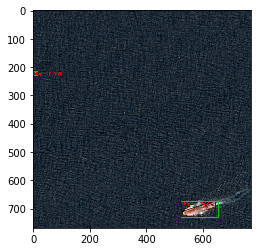

green box is predicted box, blue box is ground truth box


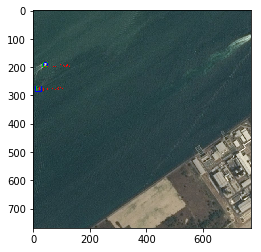

green box is predicted box, blue box is ground truth box


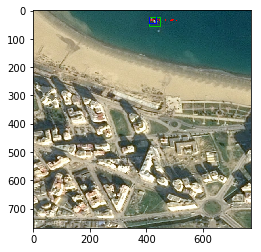

green box is predicted box, blue box is ground truth box


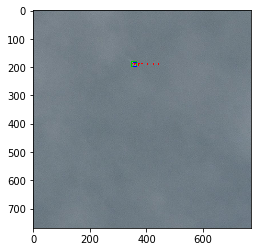

green box is predicted box, blue box is ground truth box


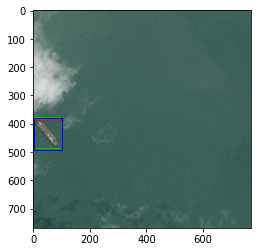

green box is predicted box, blue box is ground truth box


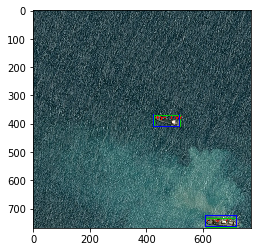

In [47]:
    if vis : num_images = 6
    for i in range(num_images):

        data = next(data_iter)
        im_data.data.resize_(data[0].size()).copy_(data[0])
        im_info.data.resize_(data[1].size()).copy_(data[1])
        gt_boxes.data.resize_(data[2].size()).copy_(data[2])
        num_boxes.data.resize_(data[3].size()).copy_(data[3])
        det_tic = time.time()
        rois, cls_prob, bbox_pred, \
        rpn_loss_cls, rpn_loss_box, \
        RCNN_loss_cls, RCNN_loss_bbox, \
        rois_label = fasterRCNN(im_data, im_info, gt_boxes, num_boxes)

        scores = cls_prob.data
        boxes = rois.data[:, :, 1:5]

        if cfg.TEST.BBOX_REG:
            # Apply bounding-box regression deltas
            box_deltas = bbox_pred.data
            if cfg.TRAIN.BBOX_NORMALIZE_TARGETS_PRECOMPUTED:
                # Optionally normalize targets by a precomputed mean and stdev
                if args.class_agnostic:
                    box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS).cuda() \
                               + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS).cuda()
                    box_deltas = box_deltas.view(1, -1, 4)
                else:
                    box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS).cuda() \
                               + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS).cuda()
                    box_deltas = box_deltas.view(1, -1, 4 * len(ships_classes))

            pred_boxes = bbox_transform_inv(boxes, box_deltas, 1)
            pred_boxes = clip_boxes(pred_boxes, im_info.data, 1)
        else:
            # Simply repeat the boxes, once for each class
            pred_boxes = np.tile(boxes, (1, scores.shape[1]))

        pred_boxes /= data[1][0][2].item()
        gt_vis_boxes = gt_boxes / data[1][0][2].item()
        gt_vis_boxes[0, :, -1] = gt_boxes[0, :, -1]
        scores = scores.squeeze()
        pred_boxes = pred_boxes.squeeze()
        det_toc = time.time()
        detect_time = det_toc - det_tic
        misc_tic = time.time()
        
        if vis:
            im = cv2.imread(data[4][0])
            im2show = np.copy(im)
            print("green box is predicted box, blue box is ground truth box")
        for j in xrange(1, len(ships_classes)):
            inds = torch.nonzero(scores[:,j]>thresh).view(-1)
            # if there is det
            if inds.numel() > 0:
                cls_scores = scores[:,j][inds]
                _, order = torch.sort(cls_scores, 0, True)
                if args.class_agnostic:
                    cls_boxes = pred_boxes[inds, :]
                else:
                    cls_boxes = pred_boxes[inds][:, j * 4:(j + 1) * 4]

                cls_dets = torch.cat((cls_boxes, cls_scores.unsqueeze(1)), 1)
                # cls_dets = torch.cat((cls_boxes, cls_scores), 1)
                cls_dets = cls_dets[order]
                keep = nms(cls_dets, cfg.TEST.NMS)
                cls_dets = cls_dets[keep.view(-1).long()]
                if vis:
                    im2show = vis_detections(im2show, ships_classes[j], cls_dets.cpu().numpy(), 0.7, gt_vis_boxes, num_boxes)
                
                num_pred_box, TP = Precision_Recall(cls_dets.cpu().numpy(), 0.7, gt_vis_boxes, num_boxes)
                total_gt_box += num_boxes.item()
                total_pred_box += num_pred_box
                total_TP += TP

                all_boxes[j][i] = cls_dets.cpu().numpy()
            else:
                all_boxes[j][i] = empty_array



        # Limit to max_per_image detections *over all classes*
        if max_per_image > 0:
            image_scores = np.hstack([all_boxes[j][i][:, -1]
                                    for j in xrange(1, len(ships_classes))])
            if len(image_scores) > max_per_image:
                image_thresh = np.sort(image_scores)[-max_per_image]
                for j in xrange(1, len(ships_classes)):
                    keep = np.where(all_boxes[j][i][:, -1] >= image_thresh)[0]
                    all_boxes[j][i] = all_boxes[j][i][keep, :]
                    
        misc_toc = time.time()
        nms_time = misc_toc - misc_tic

        sys.stdout.write('im_detect: {:d}/{:d} {:.3f}s {:.3f}s  recall {:.3f}% prescion {:.3f}% \r' \
          .format(i + 1, num_images, detect_time, nms_time, total_TP / float(total_gt_box + 0.0001) * 100, total_TP / float(total_pred_box + 0.0001) * 100))
        sys.stdout.flush()

        if vis:
            #cv2.imwrite('../demo/output/' + os.path.basename(data[4][0]), im2show)
            #pdb.set_trace()
            
            plt.imshow(cv2.cvtColor(im2show, cv2.COLOR_BGR2RGB))
            plt.show()
            
            #cv2.imshow('test', im2show)
            #cv2.waitKey(0)
